In [1]:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def get_high_low_loaders(data_set):
  train_idx_h = [h for h in range(len(data_set.targets)) if data_set.targets[h] == 0]
  train_idx_l = [l for l in range(len(data_set.targets)) if data_set.targets[l] == 1]

  # high resolution
  train_set_h = torch.utils.data.Subset(data_set, train_idx_h)
  train_loader_h = torch.utils.data.DataLoader(dataset=train_set_h, batch_size=batch_size, shuffle=False)

  # low resolution
  train_set_l = torch.utils.data.Subset(data_set, train_idx_l)
  train_loader_l = torch.utils.data.DataLoader(dataset=train_set_l, batch_size=batch_size, shuffle=False)

  return train_loader_h, train_loader_l


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 32

img_transform = transform.Compose([transform.ToTensor()]) 

# Training Set
train_set =  torchvision.datasets.ImageFolder('/content/drive/MyDrive/MLProyecto04/dataset/train/', img_transform)
# train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
print(train_set)

# Testing Set
test_set =  torchvision.datasets.ImageFolder('/content/drive/MyDrive/MLProyecto04/dataset/val/', img_transform)
# test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True, pin_memory=True)
print(test_set)

cuda:0
Dataset ImageFolder
    Number of datapoints: 1370
    Root location: /content/drive/MyDrive/MLProyecto04/dataset/train/
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 342
    Root location: /content/drive/MyDrive/MLProyecto04/dataset/val/
    StandardTransform
Transform: Compose(
               ToTensor()
           )


# New Section

In [5]:
_features = 12

In [6]:
class Encoder(nn.Module):
	def __init__(self):
		super(Encoder, self).__init__()
		self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1) # Salida 256
		self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1) # Salida 128
		self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1) # Salida 64
		self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1) # Salida 32
		self.fc = nn.Linear(in_features=512*32*32, out_features=_features)

	def forward(self, image):
		self.out1 = F.relu(self.conv1(image))
		self.out2 = F.relu(self.conv2(self.out1))
		self.out3 = F.relu(self.conv3(self.out2))
		self.out4 = F.relu(self.conv4(self.out3))
		self.out5 = self.out4.view(self.out4.size(0), -1)
		z = self.fc(self.out5)
		return z

class Decoder(nn.Module):
	def __init__(self):
		super(Decoder, self).__init__()
		self.fc    = nn.Linear(in_features=_features,out_features=512*32*32)
		self.convTran1 = nn.ConvTranspose2d(in_channels=2*512,out_channels=256, kernel_size=4, stride=2, padding=1)
		self.convTran2 = nn.ConvTranspose2d(in_channels=2*256,out_channels=128, kernel_size=4, stride=2, padding=1)
		self.convTran3 = nn.ConvTranspose2d(in_channels=2*128,out_channels=64, kernel_size=4, stride=2, padding=1)
		self.convTran4 = nn.ConvTranspose2d(in_channels=2*64,out_channels=3, kernel_size=3, stride=1, padding=1)

	def forward(self, latent, encoder):
		out = self.fc(latent)
		out = out.view(out.size(0), 512, 32, 32)
		out = F.relu(self.convTran1(torch.cat([encoder.out4, out], dim=1)))
		out = F.relu(self.convTran2(torch.cat([encoder.out3, out], dim=1)))
		out = F.relu(self.convTran3(torch.cat([encoder.out2, out], dim=1)))
		out = torch.tanh(self.convTran4(torch.cat([encoder.out1, out], dim=1)))
		return out

In [7]:
class Autoencoder(nn.Module):
   def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

   def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent, self.encoder)
        return  x_recon

In [8]:
def train(model, images_set, Epochs, loss_fn):

    images_high_loader, images_low_loader = get_high_low_loaders(images_set)

    train_loss_avg = []
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      num_batches = 0

      images_high_it = iter(images_high_loader)
    
      for image_batch, _ in tqdm(images_low_loader):
          image_batch = image_batch.to(device)
          
          image_batch_recon = model(image_batch)

          image_batch_high, _ = next(images_high_it)
          image_batch_high = image_batch_high.to(device)
          
          loss = loss_fn(image_batch_recon, image_batch_high)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          train_loss_avg[-1] += loss.item()
          num_batches += 1
          
      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
    return train_loss_avg

In [9]:
learning_rate = 0.001
autoencoder = Autoencoder()
autoencoder.to(device)

print(autoencoder)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

autoencoder.train()



Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc): Linear(in_features=524288, out_features=12, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=12, out_features=524288, bias=True)
    (convTran1): ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convTran2): ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convTran3): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convTran4): ConvTranspose2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


Autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (fc): Linear(in_features=524288, out_features=12, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=12, out_features=524288, bias=True)
    (convTran1): ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convTran2): ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convTran3): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convTran4): ConvTranspose2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [10]:
loss_result = train(autoencoder, train_set, 20, loss)

100%|██████████| 22/22 [02:35<00:00,  7.09s/it]


Epoch [1 / 20] average reconstruction error: 0.099174


100%|██████████| 22/22 [01:11<00:00,  3.27s/it]


Epoch [2 / 20] average reconstruction error: 0.005401


100%|██████████| 22/22 [01:11<00:00,  3.26s/it]


Epoch [3 / 20] average reconstruction error: 0.003332


100%|██████████| 22/22 [01:11<00:00,  3.26s/it]


Epoch [4 / 20] average reconstruction error: 0.002526


100%|██████████| 22/22 [01:11<00:00,  3.26s/it]


Epoch [5 / 20] average reconstruction error: 0.002080


100%|██████████| 22/22 [01:11<00:00,  3.26s/it]


Epoch [6 / 20] average reconstruction error: 0.001898


100%|██████████| 22/22 [01:11<00:00,  3.26s/it]


Epoch [7 / 20] average reconstruction error: 0.001733


100%|██████████| 22/22 [01:11<00:00,  3.26s/it]


Epoch [8 / 20] average reconstruction error: 0.001651


100%|██████████| 22/22 [01:11<00:00,  3.26s/it]


Epoch [9 / 20] average reconstruction error: 0.001589


100%|██████████| 22/22 [01:11<00:00,  3.26s/it]


Epoch [10 / 20] average reconstruction error: 0.001521


100%|██████████| 22/22 [01:11<00:00,  3.27s/it]


Epoch [11 / 20] average reconstruction error: 0.001463


100%|██████████| 22/22 [01:11<00:00,  3.26s/it]


Epoch [12 / 20] average reconstruction error: 0.001434


100%|██████████| 22/22 [01:11<00:00,  3.26s/it]


Epoch [13 / 20] average reconstruction error: 0.001403


100%|██████████| 22/22 [01:11<00:00,  3.26s/it]


Epoch [14 / 20] average reconstruction error: 0.001384


100%|██████████| 22/22 [01:11<00:00,  3.27s/it]


Epoch [15 / 20] average reconstruction error: 0.001372


100%|██████████| 22/22 [01:11<00:00,  3.27s/it]


Epoch [16 / 20] average reconstruction error: 0.001342


100%|██████████| 22/22 [01:11<00:00,  3.27s/it]


Epoch [17 / 20] average reconstruction error: 0.001310


100%|██████████| 22/22 [01:11<00:00,  3.27s/it]


Epoch [18 / 20] average reconstruction error: 0.001293


100%|██████████| 22/22 [01:11<00:00,  3.26s/it]


Epoch [19 / 20] average reconstruction error: 0.001279


100%|██████████| 22/22 [01:11<00:00,  3.24s/it]

Epoch [20 / 20] average reconstruction error: 0.001265


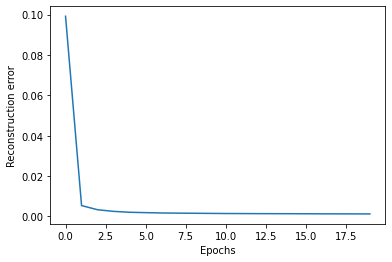

In [11]:
fig = plt.figure()
plt.plot(loss_result)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.show()

In [12]:
test_high_loader, test_low_loader = get_high_low_loaders(test_set)

autoencoder.eval()

with torch.no_grad():
  image, label = iter(test_low_loader).next()

  image = image.to(device)
  label = label.to(device)

  z = autoencoder.encoder(image)
  z = z.to(device)

  decodificado = autoencoder.decoder(z, autoencoder.encoder)
  decodificado = decodificado.to('cpu')

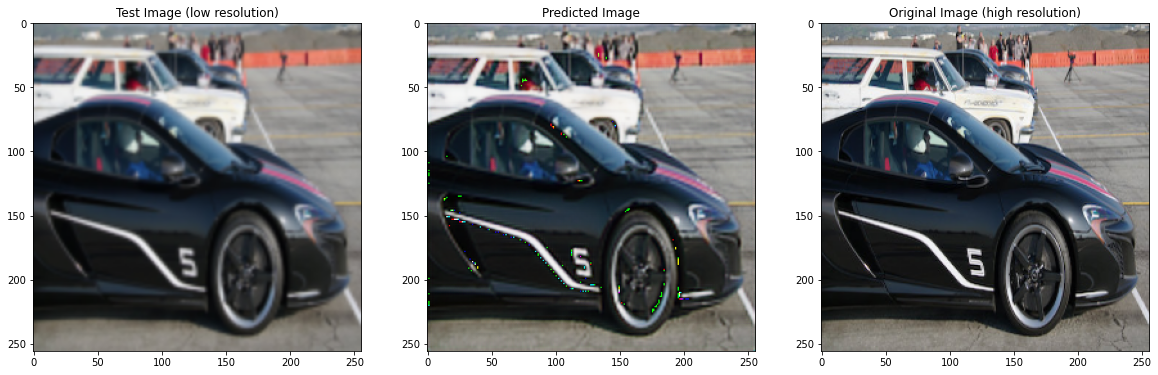

In [13]:
idx_img = 18;
images_l, _ = iter(test_low_loader).next()
images_h, _ = iter(test_high_loader).next()

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(20, 20))
ax0.set_title('Test Image (low resolution)')
ax0.imshow(transform.ToPILImage()(images_l[idx_img]))

ax1.set_title('Predicted Image')
ax1.imshow(transform.ToPILImage()(decodificado[idx_img]))

ax2.set_title('Original Image (high resolution)')
ax2.imshow(transform.ToPILImage()(images_h[idx_img]))